# package & data loading

In [4]:
import os

import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import dtreeviz
import graphviz

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

In [5]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

path_data = "data"
path_res_all = "res/worksession20230825/res_all"
path_res_by_cluster = "res/worksession20230825/by_cluster"

In [6]:
df = pd.read_csv(os.path.join(path_data, "df_final_analysis.txt"), sep="\t", header=0)
pd.set_option('display.max_columns', None)
df

,pds_code,General|Category no empty cell/not merged,General|Product type no empty cell/not merged,General|Subcategory no empty cell/not merged,Emulsifier and oil|Ratio total oil/emulsifier,Emulsifier and oil|Phospholipids g/100mL,Total Lipids g/100g product,FA_Sat g/100gFA,FA_Mono unsat g/100gFA,FA_Poly unsatg/100gFA,Pasteurization homo|P Pasto/homo bar,Pasteurization homo|T°C Pasto/Homo,Pasteurization|T°C Pasto,Pasteurization|Time Pasto sec,Sterilization US homo|P Sterilization US bar,Sterilization US homo|T°C Steril US,SterilizationDS homo|P Steril DS,SterilizationDS homo|T°C Steril DS,Sterilization|Direct/indirect Ste,Sterilization|F0,Sterilization|T°C Steril,Sterilization|Time Ste sec,Protein|Type of protein,Protein|intact / hydrolysate/am acids,"Protein|Prot level Nx6,25 g/100g product","Protein|casein Nx6,25g/100g product","Protein|whey protNx6,25g/100g product","Protein|SOY prot g/100g productNx6,25","Protein|PEA prot g/100g productNx6,25",Protein|Content kg/L,Stabilizers thickners|Type,Stabilizers thickners|Amount kg/1000L,Calcium minerals|Ca levelg/100g,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas,target,Emulsifier and oil|Emulsifier_Citrem LIQUID E472c,Emulsifier and oil|Emulsifier_Citrem POWDER E472c,Emulsifier and oil|Emulsifier_DIMODAN E471,Emulsifier and oil|Emulsifier_KIRNOL E471,Emulsifier and oil|Emulsifier_LAMEMUL E471,Emulsifier and oil|Emulsifier_Soy lecithin LIQUID E322,Emulsifier and oil|Emulsifier_Soy lecithin POWDER E322,Emulsifier and oil|Emulsifier_Sunflower lecithin E322,Emulsifier_total_amount,Emulsifier and oil|Oil_Algae oil DHA+EPA,Emulsifier and oil|Oil_Anhydrous milk fat,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Coconut oil,Emulsifier and oil|Oil_Corn oil,Emulsifier and oil|Oil_EPA,Emulsifier and oil|Oil_Egg lipids,Emulsifier and oil|Oil_MCT oil,Emulsifier and oil|Oil_OB 5,Emulsifier and oil|Oil_OB Canola/HO,Emulsifier and oil|Oil_Oil Blend Preterm 3,Emulsifier and oil|Oil_Oil Tuna Fish /DHA,Emulsifier and oil|Oil_Oil arachidonic acid / ARA,Emulsifier and oil|Oil_Oil blend Acropolis & Algae oil DHA+EPA,Emulsifier and oil|Oil_Oil blend Fish DHA EPA,Emulsifier and oil|Oil_Oil evening primrose,Emulsifier and oil|Oil_Oil fish EPA:18 DHA:12,Emulsifier and oil|Oil_Organic OB POF,Emulsifier and oil|Oil_Palm oil,Emulsifier and oil|Oil_Rapeseed oil,Emulsifier and oil|Oil_Soy oil,Emulsifier and oil|Oil_Sunflower oil,Emulsifier and oil|Oil_corn oil,Oil_total_amount,Polysaccharides_Fructose,Polysaccharides_Glucose,Polysaccharides_Glucose syrup,Polysaccharides_Isomaltulose,Polysaccharides_Lactose,Polysaccharides_Liquid maltodextrin,Polysaccharides_Maltodextrin,Polysaccharides_Starch,Polysaccharides_Sucrose,Polysaccharides_Sugar,Polysaccharides_total_amount,Protein_Calcium caseinates,Protein_Casein hydrolysate,Protein_Concentrated skimmed milk,Protein_Demineralized whey permeate 125% protein ORGANIC,Protein_Demineralized whey permeate 90,Protein_IP LQD DCI 12% No premix UF,Protein_IP PWD HYDR ACID WHEY,Protein_LIsoleucine,Protein_LLeucine,Protein_LValine,Protein_Lactofidus BP POF P1,Protein_Milk Casein Isolate,Protein_Milk Protein Concentrate,Protein_Milk Protein Isolate,Protein_Milk minerals concentrates,Protein_Pea protein,Protein_Pea protein isolate,Protein_Pepti permeate,Protein_Potassium caseinate,Protein_Skimmed milk Liquid,Protein_Skimmed milk Powder ORGANIC,Protein_Sodium caseinate,Protein_Soy protein isolate,Protein_WPC,Protein_WPC80 Native,Protein_WPC80 Native low Lactose,Protein_WPC83 Native,Protein_WPI Acid,Protein_WPI Native,Protein_WPI neutralized,Protein_WPI sweet,Protein_Whey protein hydrolysate,Protein_Whey rich in milk calcium,Protein_Yoghurt powder,Protein_whey protein hydrolysate,Protein_total_amount
0,10103262,Adult ONS,CUBITAN,NaN,30.882353,NaN,3.225499,14.388776,57.052004,28.559220,550+50,60,95.0,30.0,NaN,NaN,100+0,60.0,Indirect,15.561806,127.0,240.0,Dairy,Intact,9.634344,NaN,Na

# data preparation

### outlier and non-standard entries

In [7]:
df = df[df["Total Lipids g/100g product"] != 50]  # remove outlier product: very high total lipid, no protein

df.loc[:, "Pasteurization  homo|T°C Pasto/Homo"] = pd.to_numeric(
    df["Pasteurization  homo|T°C Pasto/Homo"].replace("72-75", '73'))
df.loc[:, "SterilizationDS homo|P Steril DS"] = df["SterilizationDS homo|P Steril DS"].replace(">180", '181')

In [8]:
def split_plus_to_numeric(df, column_to_split, remove_origin=True):
    df[[column_to_split + ' first', column_to_split + ' second']] = df[column_to_split].str.split('+',
                                                                                                  expand=True).apply(
        pd.to_numeric).fillna(0, inplace=False)
    df.drop(column_to_split, axis=1, inplace=True)
    return df


col_to_split = ["Pasteurization  homo|P Pasto/homo bar", "Sterilization US homo|P Sterilization US bar",
                "SterilizationDS homo|P Steril DS"]

for col in col_to_split:
    print(f"\t----- {col} -----")
    print("\nbefore split:\n", df[col].value_counts(), "\n\n")
    df = split_plus_to_numeric(df, col)
    print("after split:\n", df[col + ' first'].value_counts(), "\n", df[col + ' second'].value_counts(), "\n\n")


	----- Pasteurization  homo|P Pasto/homo bar -----

before split:
 Pasteurization  homo|P Pasto/homo bar
550+50      29
400+50      20
250+50      15
200+50       7
50+100       5
450+50       4
220+30       3
150+50       2
260+30       2
250 + 50     2
180+50       2
250+30       1
230+40       1
300+50       1
325+50       1
350+50       1
Name: count, dtype: int64 


after split:
 Pasteurization  homo|P Pasto/homo bar first
0.0      33
550.0    29
400.0    20
250.0    18
200.0     7
50.0      5
450.0     4
220.0     3
150.0     2
260.0     2
180.0     2
230.0     1
300.0     1
325.0     1
350.0     1
Name: count, dtype: int64 
 Pasteurization  homo|P Pasto/homo bar second
50.0     84
0.0      33
30.0      6
100.0     5
40.0      1
Name: count, dtype: int64 


	----- Sterilization US homo|P Sterilization US bar -----

before split:
 Sterilization US homo|P Sterilization US bar
250+50      5
250 + 50    4
Name: count, dtype: int64 


after split:
 Sterilization US homo|P Sterilizatio

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [9]:
df["Pasteurization  homo|T°C Pasto/Homo"] = pd.to_numeric(df["Pasteurization  homo|T°C Pasto/Homo"])

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\343474571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### ratio of oil and emulsifier

In [10]:
df["ratio_total_oil_emulsifier"] = df["Oil_total_amount"] / df["Emulsifier_total_amount"]
df.drop('Emulsifier and oil|Ratio total oil/emulsifier', axis=1, inplace=True)
df[["Oil_total_amount", "Emulsifier_total_amount", "ratio_total_oil_emulsifier"]].describe()


C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1965026945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1965026945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Oil_total_amount,Emulsifier_total_amount,ratio_total_oil_emulsifier
count,120.000000,103.000000,103.000000
mean,53.906487,2.889209,24.035595
std,50.674022,2.259902,16.283826
min,0.968000,0.450000,2.565554
25%,32.640000,1.658000,17.944957
50%,44.000000,2.050000,20.165692
75%,61.272500,3.080000,28.871495
max,403.000000,11.106000,115.868889


There are missing values in new created ratio_total_oil_emulsifier column

In [11]:
# plt.plot(df['ratio_total_oil_emulsifier'], df['target'], 'o')

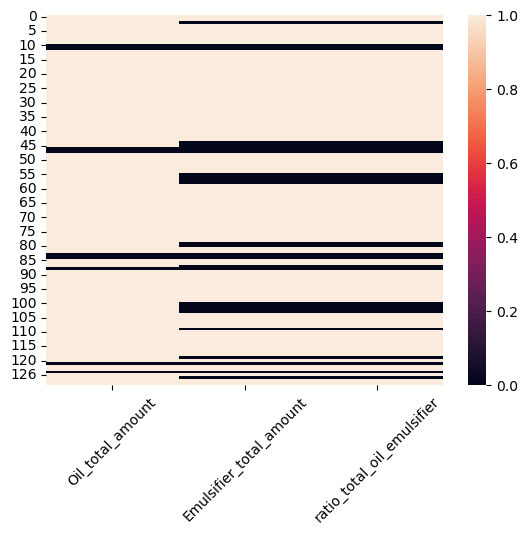

In [12]:
sns.heatmap(~df[["Oil_total_amount", "Emulsifier_total_amount", "ratio_total_oil_emulsifier"]].isna())
plt.xticks(rotation=45);

In [13]:
df[["Oil_total_amount", "target"]][df["Emulsifier_total_amount"].isna()]

,Oil_total_amount,target
2,17.620000,3.0
10,NaN,1.0
11,NaN,1.0
44,38.860000,2.0
45,67.772000,3.0
46,NaN,1.0
47,NaN,1.0
55,48.194000,3.0
56,34.950000,1.0
57,403.000000,3.0


In [14]:
df.loc[df["Oil_total_amount"].isna(), 'ratio_total_oil_emulsifier'] = 0
df["ratio_total_oil_emulsifier"].fillna(df['ratio_total_oil_emulsifier'].max() + 1, inplace=True)

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\4145699645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Missing values

Text(0.5, 1.0, 'missing values')

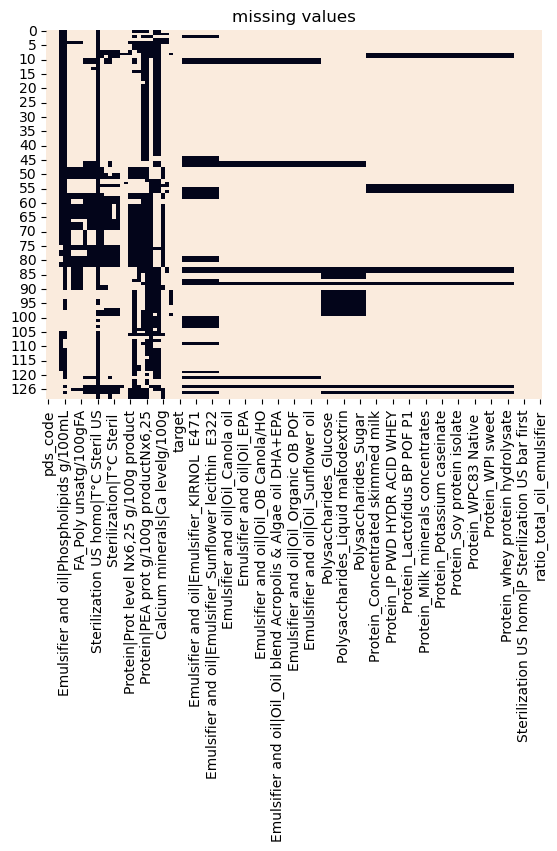

In [15]:
sns.heatmap(~df.isnull(), cbar=False)
plt.title('missing values')

### physical measures 

Text(0.5, 1.0, 'missing values of physical measurements')

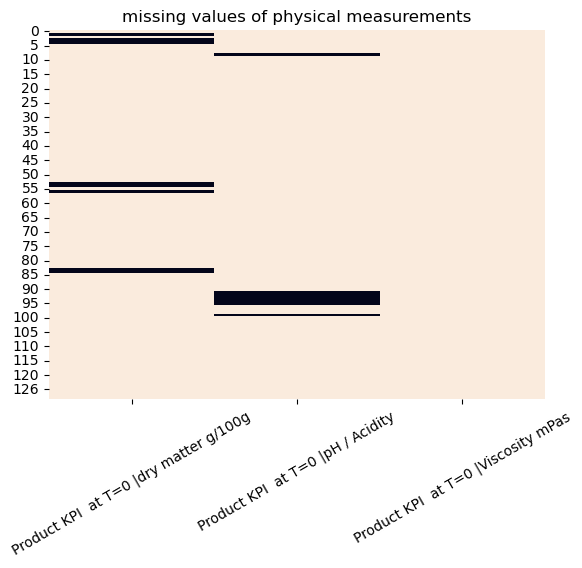

In [16]:
sns.heatmap(~df.loc[:, df.columns.str.startswith("Product KPI")].isnull(), cbar=False)
plt.xticks(rotation=30)
plt.title("missing values of physical measurements")

In [17]:
df.loc[:, df.columns.str.startswith("Product KPI")].describe()

,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas
count,121.000000,122.000000,129.000000
mean,25.809786,6.525738,4776.168992
std,11.269757,1.189250,19441.689473
min,0.185600,2.900000,2.000000
25%,18.370000,6.700000,7.000000
50%,28.310000,6.800000,20.000000
75%,33.437424,7.000000,100.000000
max,52.100000,8.000000,100000.000000


In [18]:
# fill the missing values of physical measurements with mean values
for col in df.columns[df.columns.str.startswith("Product KPI")]:
    df[col] = df[col].fillna(df[col].median())
    

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\576187657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### others: numerical values

In [19]:
col_num = df.columns[df.dtypes == 'float64']
for col in col_num[df[col_num].isnull().any()]:
    print(col)

Emulsifier and oil|Phospholipids g/100mL
Total Lipids g/100g product
FA_Sat g/100gFA
FA_Mono unsat g/100gFA
FA_Poly unsatg/100gFA
Pasteurization  homo|T°C Pasto/Homo
Pasteurization|T°C Pasto
Pasteurization|Time Pasto sec
Sterilization US homo|T°C Steril US
SterilizationDS homo|T°C Steril DS
Sterilization|F0
Sterilization|T°C Steril 
Sterilization|Time Ste sec
Protein|Prot level Nx6,25 g/100g product
Protein|casein Nx6,25g/100g product
Protein|whey protNx6,25g/100g product
Protein|SOY prot g/100g productNx6,25
Protein|PEA prot g/100g productNx6,25
Protein|Content kg/L
Stabilizers  thickners|Amount kg/1000L
Calcium minerals|Ca levelg/100g
Emulsifier and oil|Emulsifier_Citrem LIQUID  E472c
Emulsifier and oil|Emulsifier_Citrem POWDER  E472c
Emulsifier and oil|Emulsifier_DIMODAN  E471
Emulsifier and oil|Emulsifier_KIRNOL  E471
Emulsifier and oil|Emulsifier_LAMEMUL  E471 
Emulsifier and oil|Emulsifier_Soy lecithin LIQUID  E322
Emulsifier and oil|Emulsifier_Soy lecithin POWDER  E322
Emulsifie

In [20]:
col_obj = df.columns[df.dtypes == 'object']
df[col_obj[df[col_obj].isnull().any()]]

,General|Subcategory no empty cell/not merged,Sterilization|Direct/indirect Ste,Protein|Type of protein,Protein|intact / hydrolysate/am acids,Stabilizers thickners|Type
0,NaN,Indirect,Dairy,Intact,NaN
1,NaN,Indirect,Dairy,Intact,NaN
2,NaN,Indirect,Dairy,Hydrolyzed,Modified starch
3,NaN,Indirect,Dairy,Intact,NaN
4,NaN,Indirect,Dairy,Intact,NaN
...,...,...,...,...,...
125,plant proteins,NaN,NaN,Intact,NaN
126,HEHP. plant proteins,NaN,Plant based,Intact,NaN
127,PKU,NaN,Dairy,Intact,Cellulose gum
128,HEHP. plant proteins,Direct,Plant based,Intact,Cellulose gum


In [21]:
# fill the missing values
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].fillna(0)
    elif df[column].dtype == 'object':
        df[column] = df[column].fillna('NA')

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1589845567.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1589845567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_processed = df.copy()

# cluster filtering

In [23]:
# use all the products: 
cluster_name = 'all'
df_cluster = df_processed.copy()
path_res = path_res_all

In [24]:
# table of filters for clusters
df_filters = pd.DataFrame(columns=["name", "criteria_col", "col_value"])
df_filters.loc[len(df_filters.index)] = ["category_imf", "General|Category no empty cell/not merged", "Core Milks"]
df_filters.loc[len(df_filters.index)] = ["protein_type_intact", "Protein|intact / hydrolysate/am acids", "Intact"]
df_filters.loc[len(df_filters.index)] = ["protein_type_hydrolyzed", "Protein|intact / hydrolysate/am acids", "Hydrolyzed"]
df_filters.set_index('name', inplace=True)
df_filters


,criteria_col,col_value
name,,
category_imf,General|Category no empty cell/not merged,Core Milks
protein_type_intact,Protein|intact / hydrolysate/am acids,Intact
protein_type_hydrolyzed,Protein|intact / hydrolysate/am acids,Hydrolyzed


In [25]:
def get_cluster(df, cluster_name):
    criteria_col = df_filters.loc[cluster_name, "criteria_col"]
    col_value = df_filters.loc[cluster_name, "col_value"]
    path_res = os.path.join(path_res_by_cluster, cluster_name)
    if not os.path.exists(path_res):
        os.makedirs(path_res)

    df_cluster = df[df[criteria_col] == col_value]
    return df_cluster, path_res

In [26]:
# # or choose a cluster (optional)
# cluster_name = df_filters.index[2]
# df_cluster, path_res = get_cluster(df_processed, cluster_name)

In [27]:
# information of clusters
num_prod = len(df_cluster)
print("\nnumber of products in cluster", cluster_name, ":", num_prod)
print(df_cluster[["target"]].value_counts())


number of products in cluster all : 129
target
2.0       59
1.0       36
3.0       30
4.0        4
Name: count, dtype: int64


# Visualization

In [ ]:
palette_spc = sns.color_palette("Spectral",n_colors=16)
palette_spc.reverse()
palette = sns.color_palette([palette_spc[0], palette_spc[3], palette_spc[10], palette_spc[-3]])
palette

## One variable ~ target

#### numerical variable: boxplot

In [ ]:
# x = "ratio_total_oil_emulsifier"
x = "Protein_Pea protein isolate"
sns.boxplot(data=df,x=x, y="target", palette=palette)
plt.xticks(rotation=30)        
plt.show()

#### categorical variable : category plot

In [ ]:
x = "Protein|Type of protein"
sns_plot = sns.countplot(data=df, x=x,  hue="target", palette=palette)
plt.xticks(rotation=30)
plt.show()

## Two variables ~ target 

#### numerical variable - numerical variable

In [ ]:
x, y ='Oil_total_amount', 'Total Lipids g/100g product'
# x, y ="Total Lipids g/100g product", "FA_Sat g/100gFA"
sns_plot =sns.scatterplot(data=df,x=x, y=y,hue="target", palette = palette)

#### numerical variable - categorical variable

In [ ]:
# x, y = "Total Lipids g/100g product", "Protein|Type of protein"
x, y = "Calcium minerals|Ca levelg/100g", "Protein|Type of protein"
# x, y = "Calcium minerals|Ca levelg/100g", "General|Product type  no empty cell/not merged"
sns_plot = sns.boxplot(data=df[df[x]<40],x=x, y=y,hue="target", palette = palette)